In [6]:
import sys
import os
from pathlib import Path
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from rich.progress import Progress

import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets
from torchvision.io import read_image
import torchvision.transforms as tt

from utils import get_abs_path, steer_to, lazy_states_contraction, is_feasible

In [7]:
def cv2_imshow(img):
    img = np.concatenate((img[:,:,2:3], img[:,:,1:2], img[:,:,0:1]), axis=2)
    plt.imshow(img, cmap='gray')
    plt.show()


def display_image(image):
    print(image.shape)
    image = image * 255
    image = image.permute(1, 2, 0).detach().numpy()
    cv2_imshow(image)

In [22]:
project_path = get_abs_path(1)

model_dir = project_path + '/models/'
enet_filename = model_dir + 'enet.pt'
pnet_filename = model_dir + 'pnet.pt'

data_path = project_path + '/data/'
encoder_images_dir = data_path + 'encoder_images/'
train_images_dir = data_path + 'train/maps/'
train_paths_dir = data_path + 'train/planned_maps/'
valid_images_dir = data_path + 'valid/maps/'
valid_paths_dir = data_path + 'valid/planned_maps/'
test_images_dir = data_path + 'test/maps/'
test_paths_dir = data_path + 'test/planned_maps/'

train_enet = False
train_pnet = True

## **Create dataset for training encoder**

In [4]:
class ImageDataset(Dataset):

    def __init__(self, images_paths):
        self.images_paths = images_paths

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image_path = self.images_paths[idx]
        image = torch.Tensor(plt.imread(image_path))
        image = image.permute(2,1,0)
        image = image[2, :, :]
        return image, image

In [11]:
encoder_images_paths = glob.glob(encoder_images_dir + '*.png')
train_encoder_paths, test_encoder_paths = train_test_split(encoder_images_paths, test_size=0.2)
valid_encoder_paths, test_encoder_paths = train_test_split(test_encoder_paths, test_size=0.5)

train_encoder_data = ImageDataset(train_encoder_paths)
valid_encoder_data = ImageDataset(valid_encoder_paths)
test_encoder_data = ImageDataset(test_encoder_paths)

batch_size = 5 #16
train_encoder_dataloader = DataLoader(train_encoder_data, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_encoder_dataloader = DataLoader(valid_encoder_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_encoder_dataloader = DataLoader(test_encoder_data, batch_size=batch_size, shuffle=True, pin_memory=True)

torch.Size([1, 120, 120])


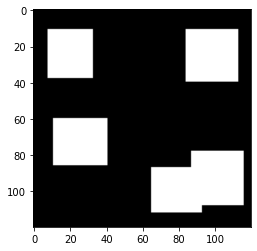

In [12]:
train_features, train_labels = next(iter(train_encoder_dataloader))
display_image(train_features[0].unsqueeze(0))

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {0} device'.format(device))

Using cpu device


## **Create encoder model**

In [14]:
class Encoder(nn.Module):
	def __init__(self, input_size):
		super(Encoder, self).__init__()
		self.flatten = nn.Flatten()
		self.dense1 = nn.Sequential(nn.Linear(input_size, 1512), nn.PReLU())
		self.dense2 = nn.Sequential(nn.Linear(1512, 556), nn.PReLU())
		self.dense3 = nn.Sequential(nn.Linear(556, 128), nn.PReLU())
		self.dense4 = nn.Linear(128, 32)

	def forward(self, x):
		x = self.flatten(x)
		x = self.dense1(x)
		x = self.dense2(x)
		x = self.dense3(x)
		x = self.dense4(x)
		return x


class Decoder(nn.Module):
	def __init__(self, output_size):
		super(Decoder, self).__init__()
		self.dense1 = nn.Sequential(nn.Linear(32, 128), nn.PReLU())
		self.dense2 = nn.Sequential(nn.Linear(128, 556), nn.PReLU())
		self.dense3 = nn.Sequential(nn.Linear(556, 1512), nn.PReLU())
		self.dense4 = nn.Sequential(nn.Linear(1512, output_size))
		self.unflatten = nn.Unflatten(1, (120, 120))

	def forward(self, x):
		x = self.dense1(x)
		x = self.dense2(x)
		x = self.dense3(x)
		x = self.dense4(x)
		x = self.unflatten(x)
		return x

In [15]:
class ResUNet(nn.Module):
    def __init__(self, input_size):
        super(ResUNet, self).__init__()
        self.Encoder = Encoder(input_size)
        self.Decoder = Decoder(input_size)

    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

Enet = ResUNet(14400).to(device)

## **Train Encoder**

In [16]:
def loss_fn(model, output, target):

    mse_loss = nn.MSELoss()

    key = str(list(model.state_dict().keys())[-2])
    last_weigths = model.state_dict()[key]

    mse = mse_loss(output, target)
    lam = 1e-3
    contractive_loss = torch.sum(Variable(last_weigths)**2, dim=1).sum().mul_(lam)

    return mse + contractive_loss


def train(model, optimizer, train_dataloader, valid_dataloader):

    for i in range(epochs):
        total_train_loss = 0
        total_valid_loss = 0

        model.train()
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            loss = loss_fn(model, pred, y)
            total_train_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            for X, y in valid_dataloader:
                X, y = X.to(device), y.to(device)

                pred = model(X)
                loss = loss_fn(model, pred, y)
                total_valid_loss += loss

        print('Epoch %d/%d' % (i+1, epochs))
        print('Train loss %f Valid loss %f' % (total_train_loss / len(train_dataloader), total_valid_loss / len(valid_dataloader)))

In [17]:
def test(model, dataloader):
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(model, pred, y).item()

    test_loss /= len(dataloader)
    print(f'Test loss: {test_loss:>8f} \n')

In [19]:
if not os.path.exists(enet_filename) or train_enet:
    optimizer = torch.optim.Adagrad(Enet.parameters(), lr=1e-3)
    epochs = 60
    train(Enet, optimizer, train_encoder_dataloader, valid_encoder_dataloader)
    test(Enet, test_encoder_dataloader)
    torch.save(Enet.state_dict(), enet_filename)
else:
    Enet.load_state_dict(torch.load(enet_filename))
    Enet.eval()

Epoch 1/60
Train loss 5.007332 Valid loss 5.049337
Epoch 2/60
Train loss 5.006386 Valid loss 5.053350
Epoch 3/60
Train loss 4.967834 Valid loss 5.045770
Epoch 4/60
Train loss 4.945927 Valid loss 5.053744
Epoch 5/60
Train loss 4.921277 Valid loss 5.048653
Epoch 6/60
Train loss 4.920617 Valid loss 5.049233
Epoch 7/60
Train loss 4.920264 Valid loss 5.045674
Epoch 8/60
Train loss 4.915776 Valid loss 5.051190
Epoch 9/60
Train loss 4.916011 Valid loss 5.048546
Epoch 10/60
Train loss 4.913297 Valid loss 5.048593
Epoch 11/60
Train loss 4.913216 Valid loss 5.049667
Epoch 12/60
Train loss 4.912775 Valid loss 5.049252
Epoch 13/60
Train loss 4.911942 Valid loss 5.048669
Epoch 14/60
Train loss 4.912378 Valid loss 5.049188
Epoch 15/60
Train loss 4.912048 Valid loss 5.049391
Epoch 16/60
Train loss 4.912246 Valid loss 5.048979
Epoch 17/60
Train loss 4.912199 Valid loss 5.049432
Epoch 18/60
Train loss 4.912133 Valid loss 5.049139
Epoch 19/60
Train loss 4.911911 Valid loss 5.049195
Epoch 20/60
Train los

## **Test Encoder**

torch.Size([1, 120, 120])


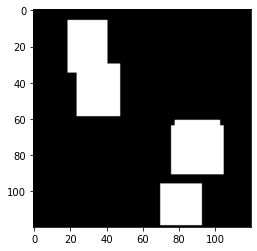

torch.Size([1, 120, 120])


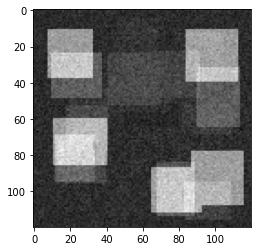

torch.Size([32])
torch.Size([1, 120, 120])


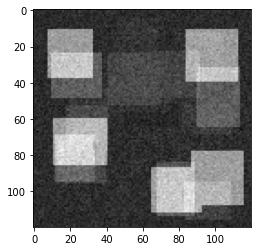

In [20]:
# Display Results
test_image, _ = next(iter(test_encoder_dataloader))
display_image(test_image[0].unsqueeze(0))

result = Enet(test_image.to(device))
display_image(result[0].cpu().unsqueeze(0))
print(Enet.Encoder(test_image.to(device))[0].shape)

encoded = Enet.Encoder(test_image.to(device))[0]
# print(encoded)
display_image(Enet.Decoder(encoded.unsqueeze(0)).cpu())

## **Create path planning dataset**

In [24]:
class PathDataset(Dataset):

    def __init__(self, images_dir, paths_dir, encoder):
        self.images_dir = images_dir
        self.paths_dir = paths_dir
        self.encoder = encoder

        images_paths = Path(images_dir).glob('*/')
        self.sample_names = [x.name[0:-4] for x in images_paths if str(x).endswith('.png')]

    def __len__(self):
        return len(self.sample_names)


    def __getitem__(self, idx):
        image_name = self.images_dir + self.sample_names[idx] + '.png'
        path_name = self.paths_dir + self.sample_names[idx] + '.json'

        image = plt.imread(image_name)
        plt.imshow(image)
        plt.show()
        print(image)
        exit()

        image = Tensor(image).to(device)
        image = image.permute(2,1,0)
        image = image[2, :, :]

        encoded_img = self.encoder(image.unsqueeze(0))[0].detach().cpu()

        x_start = 0
        X_goal = 0
        input_data = torch.cat([torch.flatten(encoded_img), x_start, x_goal])
        input_data.requires_grad = True

        return input_data, x_pred


train_dataset = PathDataset(train_images_dir, train_paths_dir, Enet.Encoder)
valid_dataset = PathDataset(valid_images_dir, valid_paths_dir, Enet.Encoder)
test_dataset = PathDataset(test_images_dir, test_paths_dir, Enet.Encoder)

# train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, pin_memory=True)

In [25]:
class PlanningNetwork(nn.Module):
    def __init__(self, p=0.5):
        super(PlanningNetwork, self).__init__()

        enc_img_size = 32
        self.dense1 = nn.Sequential(nn.Linear(enc_img_size, 1280), nn.PReLU(), nn.Dropout(p))
        self.dense2 = nn.Sequential(nn.Linear(1280, 1024), nn.PReLU(), nn.Dropout(p))
        self.dense3 = nn.Sequential(nn.Linear(1024, 896), nn.PReLU(), nn.Dropout(p))
        self.dense4 = nn.Sequential(nn.Linear(896, 768), nn.PReLU(), nn.Dropout(p))
        self.dense5 = nn.Sequential(nn.Linear(768, 512), nn.PReLU(), nn.Dropout(p))
        self.dense6 = nn.Sequential(nn.Linear(512, 384), nn.PReLU(), nn.Dropout(p))
        self.dense7 = nn.Sequential(nn.Linear(384, 256), nn.PReLU(), nn.Dropout(p))
        self.dense8 = nn.Sequential(nn.Linear(256, 128), nn.PReLU(), nn.Dropout(p))
        self.dense9 = nn.Sequential(nn.Linear(128, 64), nn.PReLU(), nn.Dropout(p))
        self.dense10 = nn.Sequential(nn.Linear(64, 32), nn.PReLU())
        self.dense11 = nn.Sequential(nn.Linear(32, 2))
        
    def forward(self, x):

        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        x = self.dense7(x)
        x = self.dense8(x)
        x = self.dense9(x)
        x = self.dense10(x)
        x = self.dense11(x)

        return x

Pnet = PlanningNetwork().to(device)
print('Model parameters:', sum(p.numel() for p in Pnet.parameters() if p.requires_grad))

Model parameters: 3693868


In [26]:
class Pnet_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output, target):

        loss = Tensor([0]).to(device)
        for i in range(len(target)):
            loss += torch.square(output[i, 0] - target[i, 0])
            loss += torch.square(output[i, 1] - target[i, 1])
        
        loss /= (target.shape[0] * 2)
        
        return loss

In [ ]:
loss_fn = Pnet_loss()
optimizer = torch.optim.Adagrad(Pnet.parameters(), lr=1e-4)

if not os.path.exists(pnet_filename) or train_pnet == True:
    epochs = 100
    for t in range(epochs):
        print(f'Epoch {t+1}\n-------------------------------')
        train(train_dataset, Pnet, loss_fn.forward, optimizer)
        test(test_dataloader_known_maps, Pnet, loss_fn.forward)
        test(test_dataloader_unknown_maps, Pnet, loss_fn.forward)
    print('Done!')
    torch.save(Pnet.state_dict(), pnet_filename)
else:
    Pnet.load_state_dict(torch.load(pnet_filename))
    Pnet.eval()

In [ ]:
# Display results
i = 0
image_path = test_konwn_maps_dir + 'map_' + str(i) + '_0.png'
image = Tensor(plt.imread(image_path)).to(device)
image = image.permute(2,1,0)
image = image[2:3, :, :]

encoded_img = Enet.Encoder(image.unsqueeze(0))[0].detach().cpu()

planned_path = Tensor(test_known_map_paths['map_' + str(i) + '_0.png'])
path_len = len(planned_path)

if path_len > 2:
    point_idx = np.random.randint(0, path_len - 2)
else:
    point_idx = 0

x_start = planned_path[point_idx] / image.shape[-1]
x_goal = planned_path[-1] / image.shape[-1]
x_pred = planned_path[point_idx + 1] / image.shape[-1]
input_data = torch.cat([torch.flatten(encoded_img), x_start, x_goal])

print(input_data.to(device).unsqueeze(0))

result = Pnet(input_data.to(device).unsqueeze(0))

i = 0
for point in [x_start, x_goal, result[0].detach().cpu()]:
    print(point)
    x, y = point.numpy()
    x*=120
    y*=120

    p = 0.6

    if i > 1:
        p = 0.25

    image[:, int(x) - 1, int(y) - 1] = p
    image[:, int(x) - 1, int(y)] = p
    image[:, int(x) - 1, int(y) + 1] = p
    image[:, int(x), int(y) - 1] = p
    image[:, int(x), int(y)] = p
    image[:, int(x), int(y) + 1] = p
    image[:, int(x) + 1, int(y) - 1] = p
    image[:, int(x) + 1, int(y)] = p
    image[:, int(x) + 1, int(y) + 1] = p
    i += 1


plt.imshow(image.permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')

print(x_start*120, x_goal*120, x_pred*120)
print(result.shape, x_pred.shape)
print(result.tolist())

In [ ]:
def Replaning(a, b):
    pass

N = 10

In [ ]:
# Algorithm 1
def MPNet(x_init, x_goal, x_obs):
    Z = Enet.Encoder(x_obs)
    Tau = NeuralPlanner(x_init, x_goal, Z)
    if Tau:
        Tau = lazy_states_contraction(Tau)

        if is_feasible(Tau):
            return Tau
        else:
            Tau_new = Replaning(Tau, Z)
            Tau_new = lazy_states_contraction(Tau_new)
            if is_feasible(Tau_new):
                return Tau_new
    return 0

In [ ]:
# Algorithm 2
def NeuralPlanner(x_start, x_goal, Z):
    Tau_a = [x_start]
    Tau_b = [x_goal]
    Tau = 0

    for i in range(N):
        x_new = Pnet(Z, Tau_a[-1], Tau_b[-1])
        Tau_a.append(x_new)
        connectable = steer_to(Tau_a[-1], Tau_b[-1])

        if connectable:
            Tau = np.concatenate((Tau_a, Tau_b))
            return Tau

        Tau_a, Tau_b = Tau_b, Tau_a

    return 0